In [1]:
import numpy as np
import matplotlib.pyplot as mt
from scipy.linalg import eigh_tridiagonal
import time

#Funciones utilizadas------------------------------------

#Diagonalización tridiagonales
def diagonalizar_tridiagonal_simetrica(diagonal_principal, diagonal_superior):
    # Calcular autovalores y autovectores
    autovalores, autovectores = eigh_tridiagonal(diagonal_principal, diagonal_superior, eigvals_only=False)
    return autovalores,autovectores

#Medir tiempo
start_time = time.time()
end_time = time.time()
execution_time = end_time - start_time
print(f"El tiempo de ejecución fue: {execution_time:.6f} segundos")

El tiempo de ejecución fue: 0.000031 segundos


In [2]:
#Creamos una función para poder obtener fácilmente el diagrama de fases dado un valor de la cte de acoplo h
def energ_estados(N,h,eps):
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    #Matriz S_z----------------
    S_z=np.diag(Ms)
    #Matriz S_+----------------

    def s_mas(m):
        return np.sqrt(S*(S+1)-m*(m+1))

    S_mas = np.zeros((2*S+1, 2*S+1))
    s_mas_vector= s_mas(np.arange(S-1, -S - 1, -1))

    for i in range(len(s_mas_vector)):
        S_mas[i, i + 1] = s_mas_vector[i]
    #Matriz S_- -------------    

    def s_menos(m):
        return np.sqrt(S*(S+1)-m*(m-1))

    S_menos = np.zeros((2*S+1, 2*S+1))
    s_menos_vector= s_menos(np.arange(S, -S, -1))
    for i in range(len(s_menos_vector)):
        S_menos[i+1, i] = s_menos_vector[i]
    #Matriz S_x
    S_x=1/2 * (S_mas + S_menos)
    #Hamiltoniano
    J=1
    epsilon=10**(-6)
    H=-(4*J)/N * np.diag(Ms*Ms)-2*h*S_x + epsilon*S_z

    #Obtenemos las autoenergías diagonalizando la matriz:
    autoenergias, autovectores = diagonalizar_tridiagonal_simetrica(np.diag(H), np.diag(H, k=1))
    magn=[]
    for i in range(int(N+1)):
        magn.append((autovectores[:,i] @ (Ms*autovectores[:,i]).T)*1/(N/2))
    return autoenergias, autovectores
N=500
energ1,auto1=energ_estados(N,0.1,1e-6)
energ2,auto2=energ_estados(N,0.3,0)

def matrix_change(auto1, auto2):
    return auto2.T @ auto1  # Producto matricial directo
U=matrix_change(auto1,auto2)

#Dado un estdo inicial |Psi>_0 = sum(a_n |u_n>)
#Supongo estado fundamental |Psi>_0 = |u_0>
c = np.zeros((N+1, 1))
c[0]=1

#Entonces en la base de de autoestados del segundo hamiltoniano los coeficientes serán:
d=U @ c

#Calculamos el valor esperado de S_z para este estado en el tiempo |Psi>_f=sum[d_n exp(-i E_n t) | v_n > ]
#<S_z>=<Psi|_f S_z |Psi>_f

def S_z(d, t, energ, auto):
    s_z = 0
    s = 1 / 2  # Spin individual
    S = int(N * s)  # Spin total
    Ms = np.arange(S, -S - 1, -1)

    # Precalcular las diferencias energéticas
    energy_diff = energ[:, None] - energ[None, :]

    # Calcular la exponencial fuera del bucle
    exp_factors = np.exp(-1j * energy_diff * t)

    # Producto de matrices: d[n]*d[m] conjugados y exp_factors
    d_d_conj = np.outer(np.conjugate(d[:, 0]), d[:, 0])

    # Sumar los términos de S_z
    for n in range(N + 1):
        for m in range(N + 1):
            s_z += np.dot(auto[:, n], (Ms * auto[:, m])) * exp_factors[n, m] * d_d_conj[n, m]

    return s_z.real / (N / 2)

print(S_z(d,0.8,energ2,auto2))



-0.9681137428895945


In [100]:
import numpy as np
N=500
#Mi funcion S_z
def S_z(d,t,energ,auto):
    s_z=0
    s=1/2#Spin individual
    S=int(N*s)#Spin total
    Ms=np.arange(S, -S - 1, -1)
    for n in range(0,len(d)):
        for m in range(0,len(d)):
            s_z+=np.conjugate(d[n,0])*d[m,0]*np.exp(-1j*(energ[n]-energ[m])*t)*(auto[:,n] @ (Ms*auto[:,m]).T)
    return s_z.real*1/(N/2)

# Llamada a la función con los valores iniciales
print(S_z(d, 0.8, energ2, auto2))




-0.9681137428895945


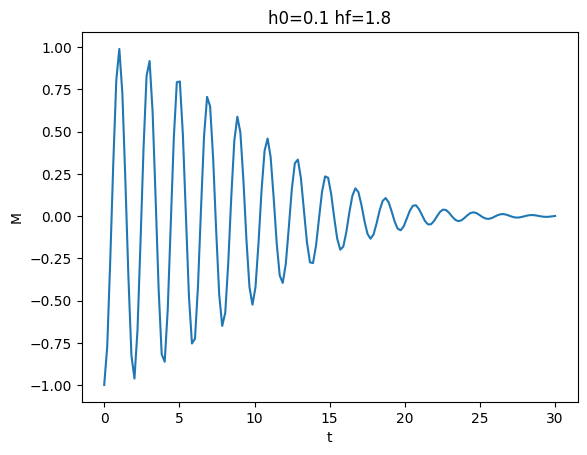

El tiempo de ejecución fue: 222.703468 segundos


In [10]:
#Representemos la evolucion temporal tras un quench-----------------------------------

#Dado un estdo inicial |Psi>_0 = sum(a_n |u_n>)
#Supongo estado fundamental |Psi>_0 = |u_0>
start_time = time.time()
def evolution_time(h0,hf,eps0,eps1,t0,tf,p,N):
    energ1,auto1=energ_estados(N,h0,eps0)
    energ2,auto2=energ_estados(N,hf,eps1)
    def matrix_change(auto1, auto2):
        return auto2.T @ auto1  # Producto matricial directo
    #Dado un estdo inicial |Psi>_0 = sum(a_n |u_n>)
    #Supongo estado fundamental |Psi>_0 = |u_0>
    c = np.zeros((N+1, 1))
    c[0]=1
    U=matrix_change(auto1,auto2)
    d=U @ c
    #Calculamos el valor esperado de S_z para este estado en el tiempo |Psi>_f=sum[d_n exp(-i E_n t) | v_n > ]
    #<S_z>=<Psi|_f S_z |Psi>_f

    def S_z(d, t, energ, auto):
        s_z = 0
        s = 1 / 2  # Spin individual
        S = int(N * s)  # Spin total
        Ms = np.arange(S, -S - 1, -1)

        # Precalcular las diferencias energéticas
        energy_diff = energ[:, None] - energ[None, :]

        # Calcular la exponencial fuera del bucle
        exp_factors = np.exp(-1j * energy_diff * t)

        # Producto de matrices: d[n]*d[m] conjugados y exp_factors
        d_d_conj = np.outer(np.conjugate(d[:, 0]), d[:, 0])

        # Sumar los términos de S_z
        for n in range(N + 1):
            for m in range(N + 1):
                s_z += np.dot(auto[:, n], (Ms * auto[:, m])) * exp_factors[n, m] * d_d_conj[n, m]

        return s_z.real / (N / 2)
    tp=np.linspace(t0,tf,p)
    S_zm=[]
    for i in tp:
        S_zm.append(S_z(d,i,energ2,auto2))
        
    mt.plot(tp,S_zm)
    mt.xlabel("t")
    mt.ylabel("M")
    mt.title(f"h0={h0} hf={hf}")
    mt.show()
    return


evolution_time(0.1,1.8,1e-6,0,0,30,150,400)

end_time = time.time()
execution_time = end_time - start_time
print(f"El tiempo de ejecución fue: {execution_time:.6f} segundos")

    

OBSERVACIONES:

hf>h0

-Observamos que partiendo de un bajo valor de h0 (h=0.1), según aumentamos hf el valor máximo del valor esperado de $S_{z}$ aumenta también. Sin embargo, el valor medio de las oscilaciones M $\neq$ 0. Esto ocurre hasta un valor de hf concreto, donde el comportamiento de la magnetización se asemeja a una onda evanescente. Si aumentamos h0 según hf se acerca a ese valor el comportamiento es errático entorno a 0, no siendo una onda evanescente perfecta.

-Cuando h0 está muy próximo a h=2 (QPT) con hf>h0, la magnetización se mueve entorno a 0 pero ya con valores que se pueden considerar nulos (1e-5). Para valores de h0 y hf mayores que 2 la magnetización es nula aproximadamente.

hf<h0

-Como vemos, el valor esperado final de $S_{z}$ $\neq$ 0 oscilando hasta estabilizarse en uno. De igual manera a partir de el valor concreto la media de la magnetización se termina anulando aproximadamente con independencia del nuevo hf. Para valores de h0>2 también es imposible volver a tener una magnetización no nula por más se cambie hf a valores muy bajos.

CONCLUSIÓN: 
1. Observamos que mediante un quench podemos pasar de un estado de simetría rota (ferromagnético) a un estado simétrico(paramagnético) pero al revés NO.

2. Dado un h0 < 2 tenemos comportamientos oscilatorios entorno a valores de magnetización no nulas, pero también para cualquier h0 $\exists$ hf tal que el sistema oscila como una onda evanescente en torno a M=0 hasta terminar con este valor. No ocurre lo mismo si se parte de h0>2 y hf<2.



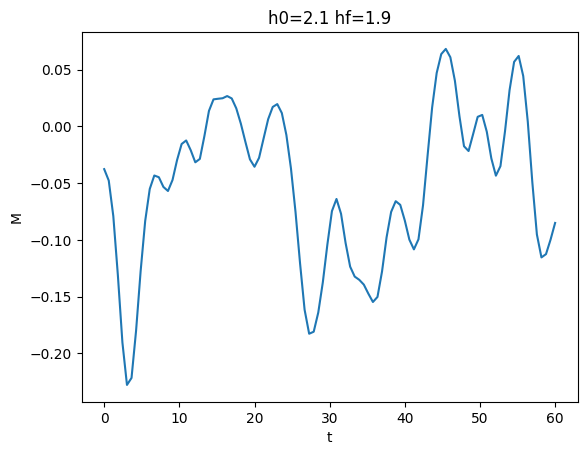

El tiempo de ejecución fue: 17.736946 segundos


In [7]:
#Código más eficiente para S_z
import matplotlib.pyplot as plt
start_time = time.time()
def energ_estados(N, h, eps):
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)

    # Matriz S_z
    S_z = np.diag(Ms)

    # Matriz S_+
    s_mas_vector = np.sqrt(S * (S + 1) - Ms[:-1] * (Ms[:-1] + 1))
    S_mas = np.diag(s_mas_vector, k=1)

    # Matriz S_-
    S_menos = np.diag(s_mas_vector, k=-1)

    # Matriz S_x
    S_x = 0.5 * (S_mas + S_menos)

    # Hamiltoniano
    J = 1
    H = -(4 * J) / N * np.diag(Ms**2) - 2 * h * S_x + eps * S_z

    # Diagonalización
    autoenergias, autovectores = np.linalg.eigh(H)
    return autoenergias, autovectores

def evolution_time(h0, hf, eps0, eps1, t0, tf, p, N):
    energ1, auto1 = energ_estados(N, h0, eps0)
    energ2, auto2 = energ_estados(N, hf, eps1)

    # Cambio de base
    U = auto2.T @ auto1

    # Estado inicial
    c = np.zeros((N + 1, 1))
    c[0] = 1
    d = U @ c

    # Precalculos
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)
    sz_matrix = np.tensordot(auto2.T, (Ms[:, None] * auto2), axes=([1], [0]))

    # Cálculo de S_z en función del tiempo
    energy_diff = energ2[:, None] - energ2[None, :]
    d_d_conj = np.outer(np.conjugate(d[:, 0]), d[:, 0])

    tp = np.linspace(t0, tf, p)
    S_zm = [
        np.sum(sz_matrix * np.exp(-1j * energy_diff * t) * d_d_conj).real / (N / 2)
        for t in tp
    ]

    plt.plot(tp, S_zm)
    plt.xlabel("t")
    plt.ylabel("M")
    plt.title(f"h0={h0} hf={hf}")
    plt.show()

evolution_time(2.1, 1.9, 1e-6, 1e-6, 0, 60, 100, 1000)
end_time = time.time()
execution_time = end_time - start_time
print(f"El tiempo de ejecución fue: {execution_time:.6f} segundos")


# Distribución de energía

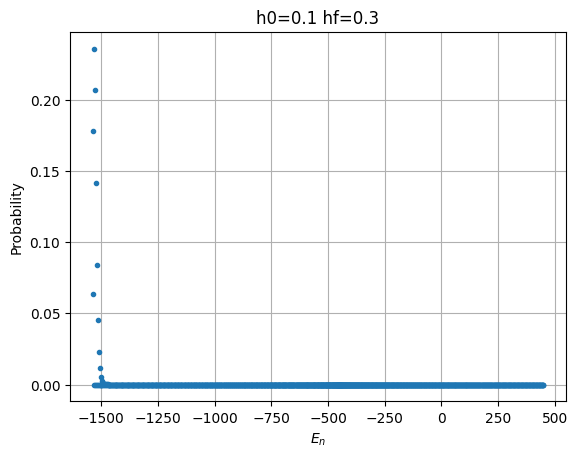

La máxima probabilidad se da para E_n = -1529.6734220465137


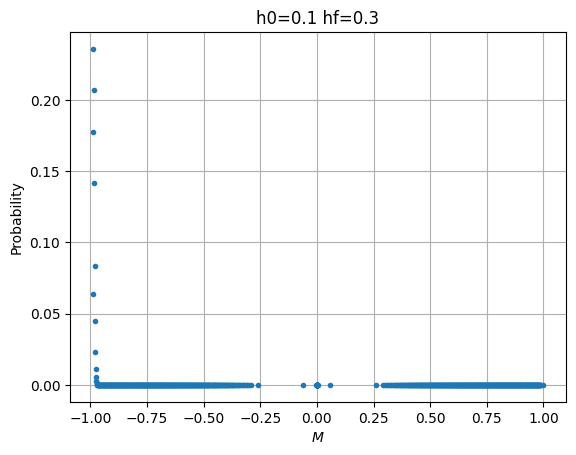

La máxima probabilidad se da para M = -0.9867324021283523


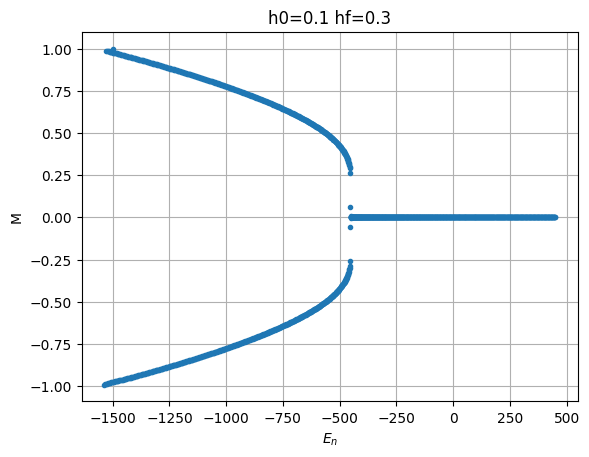

In [46]:

def energ_estados(N, h, eps):
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)

    # Matriz S_z
    S_z = np.diag(Ms)

    # Matriz S_+
    s_mas_vector = np.sqrt(S * (S + 1) - Ms[:-1] * (Ms[:-1] + 1))
    S_mas = np.diag(s_mas_vector, k=1)

    # Matriz S_-
    S_menos = np.diag(s_mas_vector, k=-1)

    # Matriz S_x
    S_x = 0.5 * (S_mas + S_menos)

    # Hamiltoniano
    J = 1
    H = -(4 * J) / N * np.diag(Ms**2) - 2 * h * S_x + eps * S_z

    # Diagonalización
    autoenergias, autovectores = np.linalg.eigh(H)
    return autoenergias, autovectores

def distribucion_energias(N,h0,hf,eps0,eps1):
    s = 0.5
    S = int(N * s)
    Ms = np.arange(S, -S - 1, -1)
#Autovalores y autoestados en ambos hamiltonianos
    energ1, auto1 = energ_estados(N, h0, eps0)
    energ2, auto2 = energ_estados(N, hf, eps1)

# Cambio de base
    U = auto2.T @ auto1

# Estado inicial
    c = np.zeros((N + 1, 1))
    c[0] = 1
    d = U @ c
    prob=np.abs(d)**2

#Magnetización
    magn=[]
    for i in range(int(N+1)):
        magn.append((auto2[:,i] @ (Ms*auto2[:,i]).T)*1/(N/2))
    plt.plot(energ2,prob,'.')
    plt.xlabel(r"$E_{n}$")
    plt.ylabel("Probability")
    plt.title(f"h0={h0} hf={hf}")
    plt.grid()
    plt.show()
    print(f"La máxima probabilidad se da para E_n = {energ2[np.argmax(prob)]}")

    plt.plot(magn,prob,'.')
    plt.xlabel(r"$M$")
    plt.ylabel("Probability")
    plt.title(f"h0={h0} hf={hf}")
    plt.grid()
    plt.show()
    print(f"La máxima probabilidad se da para M = {magn[np.argmax(prob)]}")

    plt.plot(energ2,magn,'.')
    plt.xlabel(r"$E_{n}$")
    plt.ylabel("M")
    plt.title(f"h0={h0} hf={hf}")
    plt.grid()
    plt.show()

    
    return
 

Como se observa principalmente en probabilidad frente a M, las evoluciones temporales son coherentes con la gráfica, pues el pico de probabilidad se sitúa en M=0 cuando en la evolución temporal vemos como una onda que tiende a M=0, y se sitúa en M distinta de 0 cuando observamos estas ondas pero sin que se estabilicen en M=0 en la evolución temporal.